In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm

os.environ["CUDA_VISIBLE_DEVICES"] = '-1'

from ssd_model import DSOD300, DSOD512
from ssd_data import InputGenerator
from ssd_utils import PriorUtil
from ssd_metric import confusion_matrix, plot_confusion_matrix, accuracy, evaluate_results
from utils.model import load_weights

In [12]:
from keras import backend as K
K.clear_session()

In [2]:
from data_voc import GTUtility
gt_util = GTUtility('./data/VOC2007test/')

In [ ]:
from data_coco import GTUtility
gt_util = GTUtility('./data/COCO/', validation=True)
gt_util = gt_util.convert_to_voc()

In [ ]:
model = DSOD300(input_shape=(300, 300, 3), num_classes=gt_util.num_classes); confidence_threshold = 0.275
#model = DSOD300(input_shape=(600, 600, 3), num_classes=gt_util.num_classes); confidence_threshold = 0.35
load_weights(model, './checkpoints/201808261035_dsod300fl_voccoco/weights.110.h5')

In [13]:
model = DSOD512(num_classes=gt_util.num_classes); confidence_threshold = 0.275
load_weights(model, './checkpoints/202009011128_dsod512fl_voccoco/weights.009.h5')

In [14]:
prior_util = PriorUtil(model)

inputs, data = gt_util.sample_batch(min(gt_util.num_samples, 10000), 0, input_size=model.image_size)
#inputs, data = gt_util.sample_batch(min(gt_util.num_samples, 10000), 0, input_size=model.image_size, preserve_aspect_ratio=True)

#gen = InputGenerator(gt_util, prior_util, min(gt_util.num_samples, 10000), model.image_size, augmentation=True)
#inputs, data = next(gen.generate(encode=False))

preds = model.predict(inputs, batch_size=1, verbose=1)

4952/4952 [==============================] - 2088s 422ms/step


### Grid search

In [15]:
steps = np.arange(0.05, 1, 0.05)

fmes_grid = np.zeros((len(steps)))

for i, t in enumerate(steps):
    results = [prior_util.decode(p, t) for p in preds]
    fmes = evaluate_results(data, results, gt_util, iou_thresh=0.5, max_dets=100, return_fmeasure=True)
    fmes_grid[i] = fmes
    print('threshold %.2f f-measure %.2f' % (t, fmes))

threshold 0.05 f-measure 0.10
threshold 0.10 f-measure 0.23
threshold 0.15 f-measure 0.33
threshold 0.20 f-measure 0.36
threshold 0.25 f-measure 0.36
threshold 0.30 f-measure 0.34
threshold 0.35 f-measure 0.30
threshold 0.40 f-measure 0.25
threshold 0.45 f-measure 0.20
threshold 0.50 f-measure 0.15
threshold 0.55 f-measure 0.11
threshold 0.60 f-measure 0.07
threshold 0.65 f-measure 0.04
threshold 0.70 f-measure 0.02
threshold 0.75 f-measure 0.01
threshold 0.80 f-measure 0.00
threshold 0.85 f-measure 0.00
threshold 0.90 f-measure nan
threshold 0.95 f-measure nan


0.9000000000000001 nan


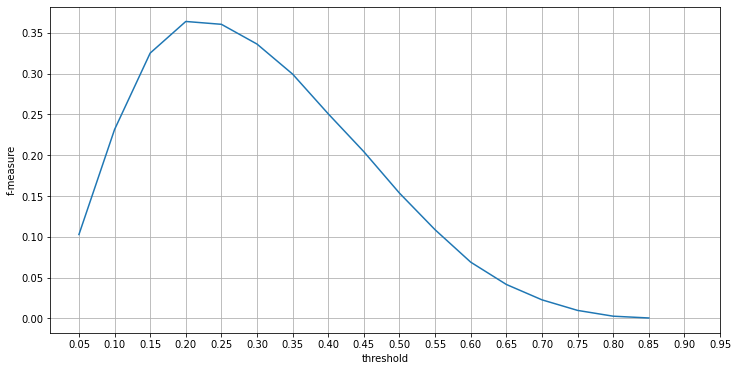

In [16]:
max_idx = np.argmax(fmes_grid)
print(steps[max_idx], fmes_grid[max_idx])
plt.figure(figsize=[12,6])
plt.plot(steps, fmes_grid)
plt.plot(steps[max_idx], fmes_grid[max_idx], 'or')
plt.xticks(steps)
plt.grid()
plt.xlabel('threshold')
plt.ylabel('f-measure')
plt.show()

In [ ]:
confidence_threshold = 0.275 # pascal voc 2007 test
#confidence_threshold = 0.550 # pascal voc 2012 test
#confidence_threshold = 0.125 # ms coco test

### Precision-recall curve, mean Average Precision

100%|██████████| 4952/4952 [00:40<00:00, 121.99it/s]


Class                     TP       FP       FN     AP
 1 Aeroplane             158     7525      153  0.292
 2 Bicycle               216    12841      173  0.218
 3 Bird                  294    15731      282  0.077
 4 Boat                  155    16463      238  0.071
 5 Bottle                285    46573      372  0.080
 6 Bus                   191    18935       63  0.344
 7 Car                  1091    24485      450  0.544
 8 Cat                   282    18522       88  0.261
 9 Chair                 666    51468      708  0.137
10 Cow                   206    19394      123  0.129
11 Diningtable           218    27185       81  0.382
12 Dog                   425    21619      105  0.111
13 Horse                 284    10550      111  0.174
14 Motorbike             245    16808      124  0.335
15 Person               3537    40993     3202  0.400
16 Pottedplant           261    20955      331  0.102
17 Sheep                 181     7871      130  0.190
18 Sofa                  296

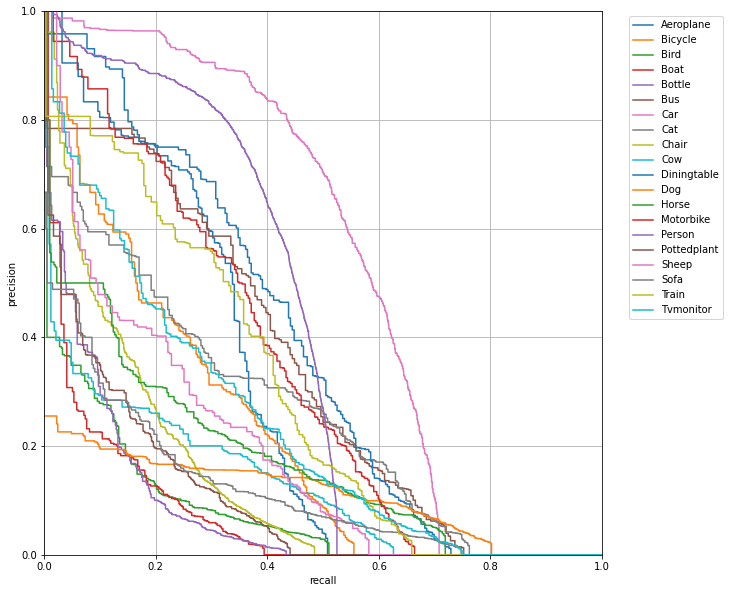

In [18]:
results = [prior_util.decode(p, confidence_threshold=0.01, keep_top_k=400) for p in tqdm(preds)]
evaluate_results(data, results, gt_util, iou_thresh=0.5, max_dets=100)

### Confusion matrix of local predictions

In [ ]:
results = [prior_util.decode(p, confidence_threshold) for p in tqdm(preds)]
encoded_gt = [prior_util.encode(d) for d in tqdm(data)]

y_true_all = []
y_pred_all = []

for i in range(len(data)):
    y_true = np.argmax(encoded_gt[i][:,4:], axis=1)
    y_pred = np.argmax(preds[i][:,4:], axis=1)
    #prior_object_idx = np.where(y_true)[0] # gt prior box contains object
    prior_object_idx = np.where(y_true+y_pred)[0] # gt or prediction prior box contains object
    y_true_all.extend(y_true[prior_object_idx])
    y_pred_all.extend(y_pred[prior_object_idx])
    
#y_pred_all = [ 17 for i in y_pred_all]

cm = confusion_matrix(y_true_all, y_pred_all, gt_util.num_classes)
plot_confusion_matrix(cm, gt_util.classes, figsize=[12]*2)
accuracy(y_true_all, y_pred_all)

### Examples

In [ ]:
for i in np.random.randint(0, len(inputs), 30):
    plt.figure(figsize=[8]*2)
    gt_util.plot_input(inputs[i])
    #gt_util.plot_gt(data[i])
    prior_util.plot_results(results=results[i], classes=gt_util.classes, gt_data=data[i], 
                            confidence_threshold=confidence_threshold)
    plt.axis('off')
    plt.show()